### Import Dataset and Organize the Dataframe

In [1]:
# Let's import the necessary libraries
import pandas as pd

# Read in the dataset 
df = pd.read_csv('wgm_full_wave2_public_file_final_csv.csv',na_values=" ", keep_default_na=False,low_memory=False)

# Organizing the dataset:

# DEMOGRAPHIC INFORMATION
# Copy the original dataframe and select the columns associated with demograph information. 
#  These demographic factors are categorical variables; convert the datatype to 'categorical'
demographicInfo = df.copy()[['Global11Regions','Gender', 'Age','age_var3',
                             'Education','Household_Income','wbi',
                             'Subjective_Income','EMP_2010']].astype('category')

# First we add a new level/category of '99.0' to the feature:
demographicInfo['Household_Income'] = demographicInfo['Household_Income'].cat.add_categories(99.0)
demographicInfo['EMP_2010'] = demographicInfo['EMP_2010'].cat.add_categories(99.0)

# Impute the NaN values with '99.0' ('Don't Know/Refused')
demographicInfo['Household_Income'].fillna(99.0, inplace=True)
demographicInfo['EMP_2010'].fillna(99.0, inplace=True)


# QUESTIONNAIRE DATA
# Perception of science:
sciPercep = df.copy().iloc[:,6:28].astype('category')
sciPercep['W3'] = sciPercep['W3'].cat.add_categories(99.0) # Add a new level to 'W3'
sciPercep['W3'].fillna(99.0, inplace=True) # Impute the NaN values with the new level

# Impute the NaN entries with the values stated above
sciPercep['W4'].fillna(99.0, inplace=True)
sciPercep['W5B'].fillna(99.0, inplace=True)
sciPercep['W5D'].fillna(99.0, inplace=True)
sciPercep['W7C'].fillna(99.0, inplace=True)


# Perceptions about Climate Change
climateChange = df.copy().iloc[:,28:31].astype('category')
# Impute the NaN entries with the values stated above
climateChange['W14'].fillna(99.0, inplace=True)
climateChange['W15'].fillna(99.0, inplace=True)


# Perceptions of science with respect to COVID-19 pandemic
covidPercep = df.copy().iloc[:,31:38].astype('category')
# Impute the NaN entries with the values stated above
covidPercep['W15_1A'].fillna(99.0, inplace=True)
covidPercep['W15_1B'].fillna(99.0, inplace=True)
covidPercep['W15_1C'].fillna(99.0, inplace=True)
covidPercep['W15_1D'].fillna(99.0, inplace=True)
covidPercep['W15_1E'].fillna(99.0, inplace=True)
covidPercep['W15_2A'].fillna(99.0, inplace=True)
covidPercep['W15_2B'].fillna(99.0, inplace=True)


# Perceptions about physical and mental health:
sciHealth = df.copy().iloc[:,38:67].astype('category')
# Impute the NaN entries with the values stated above for MH3A to MH5 + MH7A
sciHealth['MH3A'].fillna(99.0, inplace=True)
sciHealth['MH3B'].fillna(99.0, inplace=True)
sciHealth['MH3C'].fillna(99.0, inplace=True)
sciHealth['MH3D'].fillna(99.0, inplace=True)
sciHealth['MH4A'].fillna(99.0, inplace=True)
sciHealth['MH4B'].fillna(99.0, inplace=True)
sciHealth['MH5'].fillna(99.0, inplace=True)
sciHealth['MH7A'].fillna(99.0, inplace=True)
# Impute the NaN entries with the values stated above for MH1 and MH6
sciHealth['MH1'].fillna(99, inplace=True)
sciHealth['MH6'].fillna(99, inplace=True)


# Social Media Usage
socialMedia = df.copy().iloc[:,67:70].astype('category')
# Impute the NaN values
socialMedia['W28'].fillna(99.0, inplace=True)
socialMedia['W29'].fillna(99.0, inplace=True)


# Religion
religion = df.copy()['W30'].astype('category')

# Impute missing values
religion.fillna(99.0, inplace=True)

Generating the final dataset used for Classification

In [2]:
questionDataset = pd.concat([sciPercep, climateChange, covidPercep,sciHealth.iloc[:,0:10], socialMedia, religion.to_frame()],axis=1)
# Remove 'Age' and keep 'age_var3'
demographicInfo = demographicInfo.drop('Age',axis=1)

dataset = pd.concat([demographicInfo, questionDataset],axis=1)
dataset.shape # 119 088 entries and 54 columns/features

(119088, 54)

In [3]:
dataset = dataset[(dataset['MH7A'] == 1.0) | (dataset['MH7A'] == 2.0)]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116810 entries, 0 to 119087
Data columns (total 54 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Global11Regions    116810 non-null  category
 1   Gender             116810 non-null  category
 2   age_var3           116810 non-null  category
 3   Education          116810 non-null  category
 4   Household_Income   116810 non-null  category
 5   wbi                116810 non-null  category
 6   Subjective_Income  116810 non-null  category
 7   EMP_2010           116810 non-null  category
 8   W1                 116810 non-null  category
 9   W2                 116810 non-null  category
 10  W3                 116810 non-null  category
 11  W4                 116810 non-null  category
 12  W5A                116810 non-null  category
 13  W5B                116810 non-null  category
 14  W5C                116810 non-null  category
 15  W5D                116810 non-null

### Classification

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Splitting the dataset into features and target/label:

In [5]:
y = dataset['MH7A'] # The label: MH7A 
y.shape # 119 088 entries

(116810,)

In [6]:
X = dataset.drop(columns='MH7A') # The independent variables/features used for classification
X.shape # 119 088 entries and 54 columns/features

(116810, 53)

Split the dataset into training/testing sets using a 70/30 split:

In [7]:
# 70% training and 30% test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [8]:
X_train.shape

(81767, 53)

In [9]:
X_test.shape

(35043, 53)

### Feature Selection

Based on the chi-squared test scores shown, let's set a threshold of 2000. Any features that have a score greater than 2000 will be included as a feature in future models.

Feature 0: 895.456901
Feature 1: 16.520788
Feature 2: 429.357539
Feature 3: 206.765457
Feature 4: 846.724313
Feature 5: 39.561801
Feature 6: 711.372076
Feature 7: 59.517958
Feature 8: 78.933518
Feature 9: 264.673228
Feature 10: 802.682457
Feature 11: 839.676847
Feature 12: 149.290457
Feature 13: 3299.105630
Feature 14: 18.832843
Feature 15: 8.387719
Feature 16: 13.242311
Feature 17: 1258.828622
Feature 18: 830.888446
Feature 19: 97.691066
Feature 20: 767.574079
Feature 21: 1735.630512
Feature 22: 1669.939171
Feature 23: 383.940229
Feature 24: 974.274333
Feature 25: 1157.068725
Feature 26: 2035.334654
Feature 27: 1943.582749
Feature 28: 246.275184
Feature 29: 3425.815844
Feature 30: 429.198579
Feature 31: 852.821591
Feature 32: 1377.413362
Feature 33: 11101.115091
Feature 34: 14531.825730
Feature 35: 15976.569347
Feature 36: 14023.354942
Feature 37: 12520.446012
Feature 38: 9385.945667
Feature 39: 9706.794076
Feature 40: 133.277412
Feature 41: 1182.391846
Feature 42: 10621.389196
Featur

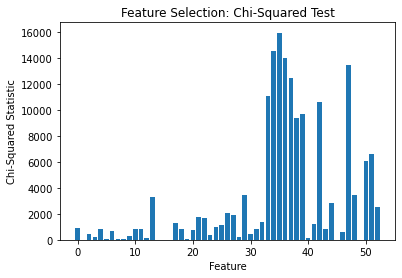

In [76]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# # Using the Chi-Squared test to identify features that are NOT independent of the target variable/label
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('Feature Selection: Chi-Squared Test')
plt.ylabel('Chi-Squared Statistic')
plt.xlabel('Feature')
plt.show()

In [86]:
selector = SelectKBest(score_func=chi2, k=17)
selector.fit(X_train, y_train)
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
X_fs = X_train.iloc[:,cols_idxs]

In [87]:
X_fs

,W5B,W11A,MH2B,W15_1A,W15_1B,W15_1C,W15_1D,W15_1E,W15_2A,W15_2B,MH3B,MH3D,MH5,MH6,W28,W29,W30
43560,2.0,1,2,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,99,99.0,99.0,1.0
62908,4.0,1,99,4.0,3.0,1.0,1.0,99.0,3.0,1.0,3.0,99.0,1.0,2,3.0,3.0,3.0
34789,2.0,1,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2,99.0,99.0,2.0
55266,1.0,2,1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0
75584,99.0,1,3,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50736,1.0,3,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2,3.0,3.0,4.0
99189,99.0,1,4,99.0,1.0,2.0,2.0,99.0,1.0,1.0,2.0,3.0,1.0,1,1.0,2.0,1.0
5214,3.0,1,1,3.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1,3.0,2.0,2.0
78640,3.0,1,3,2.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,3.0,2,2.0,3.0,1.0


In [88]:
# Let's add the demographic features into X_fs:
X_train_fs = pd.concat([X_train.iloc[:,1], X_fs],axis=1)
X_train_fs

,Gender,W5B,W11A,MH2B,W15_1A,W15_1B,W15_1C,W15_1D,W15_1E,W15_2A,W15_2B,MH3B,MH3D,MH5,MH6,W28,W29,W30
43560,2,2.0,1,2,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,99,99.0,99.0,1.0
62908,1,4.0,1,99,4.0,3.0,1.0,1.0,99.0,3.0,1.0,3.0,99.0,1.0,2,3.0,3.0,3.0
34789,2,2.0,1,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2,99.0,99.0,2.0
55266,2,1.0,2,1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0
75584,2,99.0,1,3,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50736,2,1.0,3,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2,3.0,3.0,4.0
99189,1,99.0,1,4,99.0,1.0,2.0,2.0,99.0,1.0,1.0,2.0,3.0,1.0,1,1.0,2.0,1.0
5214,2,3.0,1,1,3.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1,3.0,2.0,2.0
78640,2,3.0,1,3,2.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,3.0,2,2.0,3.0,1.0


Let's define some scoring metrics

In [20]:
# Define custom scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

#### Baseline Classifier using Decision Tree
- gini impurity measure
- using all 53 features

In [78]:
# Create Decision Tree Classifier object
clfDT = DecisionTreeClassifier(random_state=1)

# Fit the model
clfDT.fit(X_train, y_train)

# Predicting labels for the Test Set
y_pred = clfDT.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

[[ 2598  4582]
 [ 5313 22550]]


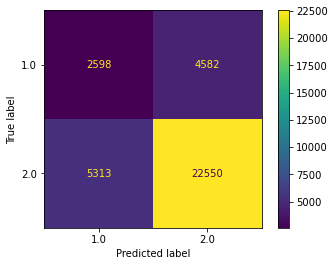

In [79]:
cm = confusion_matrix(y_test, y_pred, labels=clfDT.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clfDT.classes_)
disp.plot()
plt.show()

In [82]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))

Accuracy: 0.7176326227777302
Precision: 0.32840348881304515
Recall: 0.36183844011142063
F1 Score: 0.3443111788483202
MCC: 0.16523814459864605


In [83]:
# Create Decision Tree Classifier object
clfDT = DecisionTreeClassifier(random_state=1)

# Perform 10-fold cross-validation with custom scoring metrics
cv_results = cross_validate(clfDT, X_train, y_train, cv=10, scoring=scoring)

# Print the results
print(cv_results)

{'fit_time': array([1.18326211, 1.19925976, 1.15625978, 1.1592741 , 1.17124963,
       1.16127563, 1.184268  , 1.19426966, 1.20927238, 1.17026782]), 'score_time': array([0.02196264, 0.02100515, 0.02000427, 0.01900434, 0.01900363,
       0.02031946, 0.02100372, 0.02100372, 0.02000475, 0.01900411]), 'test_accuracy': array([0.72385961, 0.70820594, 0.70649382, 0.7239819 , 0.72165831,
       0.72092454, 0.70673841, 0.71550881, 0.72284736, 0.72101272]), 'test_precision': array([0.34359806, 0.31365314, 0.30545062, 0.33926585, 0.34130781,
       0.33370105, 0.30615551, 0.32654155, 0.34109367, 0.33551913]), 'test_recall': array([0.3787969 , 0.35437761, 0.33710542, 0.36331149, 0.38237046,
       0.36033353, 0.3375    , 0.3627159 , 0.37522335, 0.36569387]), 'test_f1_score': array([0.36033994, 0.33277405, 0.3204983 , 0.35087719, 0.36067416,
       0.3465063 , 0.32106455, 0.34367946, 0.35734543, 0.34995725])}


In [84]:
# 10-fold cross-validation
print("Baseline Classifier F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_results['test_f1_score']),
                                                                      std=np.std(cv_results['test_f1_score'])))

Baseline Classifier F1-score
Mean: 0.344371664180459
Std: 0.01419611223293664


#### Classification using smaller Feature Set

First let's update X_test with the new features:

In [89]:
X_train_fs.info() # 18 features now being used

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81767 entries, 43560 to 99685
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Gender  81767 non-null  category
 1   W5B     81767 non-null  category
 2   W11A    81767 non-null  category
 3   MH2B    81767 non-null  category
 4   W15_1A  81767 non-null  category
 5   W15_1B  81767 non-null  category
 6   W15_1C  81767 non-null  category
 7   W15_1D  81767 non-null  category
 8   W15_1E  81767 non-null  category
 9   W15_2A  81767 non-null  category
 10  W15_2B  81767 non-null  category
 11  MH3B    81767 non-null  category
 12  MH3D    81767 non-null  category
 13  MH5     81767 non-null  category
 14  MH6     81767 non-null  category
 15  W28     81767 non-null  category
 16  W29     81767 non-null  category
 17  W30     81767 non-null  category
dtypes: category(18)
memory usage: 2.0 MB


In [90]:
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
X_test_fs = X_test.iloc[:,cols_idxs]

# The testing set to be used
X_test_fs = pd.concat([X_test.iloc[:,1],X_test_fs],axis=1)

In [91]:
X_test_fs.shape

(35043, 18)

#### 10-fold Cross-validation

In [92]:
# Create Decision Tree Classifier object
clfDT_fs = DecisionTreeClassifier(random_state=1)

# Perform 10-fold cross-validation with custom scoring metrics
cv_results = cross_validate(clfDT_fs, X_train_fs, y_train, cv=10, scoring=scoring)

# Print the results
print(cv_results)

{'fit_time': array([0.38009787, 0.3730824 , 0.41309309, 0.44009924, 0.38408566,
       0.39008141, 0.37709045, 0.37909031, 0.38310409, 0.4120934 ]), 'score_time': array([0.01599789, 0.01499772, 0.01799822, 0.01601601, 0.01400828,
       0.01501107, 0.01599836, 0.01699114, 0.01798749, 0.01500082]), 'test_accuracy': array([0.70013452, 0.69744405, 0.69353063, 0.70527088, 0.69866699,
       0.70942889, 0.69988994, 0.70266634, 0.69508317, 0.70034247]), 'test_precision': array([0.30489652, 0.29457364, 0.28762198, 0.30568846, 0.29177719,
       0.314923  , 0.29171152, 0.29697624, 0.29106776, 0.29656992]), 'test_recall': array([0.35973794, 0.33948779, 0.33353186, 0.34246575, 0.32757594,
       0.35318642, 0.32261905, 0.32757594, 0.33770101, 0.33472305]), 'test_f1_score': array([0.33005464, 0.31543996, 0.30888031, 0.32303371, 0.30864198,
       0.33295901, 0.30638779, 0.31152648, 0.31265509, 0.31449356])}


In [93]:
# 10-fold cross-validation
print("Baseline Classifier F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_results['test_f1_score']),
                                                                      std=np.std(cv_results['test_f1_score'])))

Baseline Classifier F1-score
Mean: 0.31640725253262963
Std: 0.008740506632035176


#### Using the Testing Set:

In [94]:
# Create Decision Tree Classifier object
clfDT_fs = DecisionTreeClassifier(random_state=1)

# Fit the model
clfDT_fs.fit(X_train_fs, y_train)

# Predicting labels for the Test Set
y_pred_fs = clfDT_fs.predict(X_test_fs)

print(confusion_matrix(y_test, y_pred_fs))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

[[ 2446  4734]
 [ 5598 22265]]


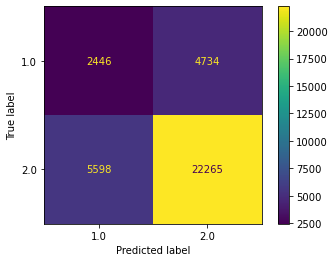

In [95]:
cm = confusion_matrix(y_test, y_pred_fs, labels=clfDT_fs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clfDT_fs.classes_)
disp.plot()
plt.show()

In [96]:
print("Accuracy:", accuracy_score(y_test, y_pred_fs))
print("Precision:", precision_score(y_test, y_pred_fs))
print("Recall:", recall_score(y_test, y_pred_fs))
print("F1 Score:", f1_score(y_test, y_pred_fs))
print("MCC:", matthews_corrcoef(y_test, y_pred))

Accuracy: 0.7051622292611934
Precision: 0.30407757334659374
Recall: 0.3406685236768802
F1 Score: 0.3213347346295323
MCC: 0.16523814459864605


### Balancing the dataset
Let's apply an imbalance treatment by undersampling the majority class (i.e. 'No' to MH7A)

In [97]:
from imblearn.under_sampling import RandomUnderSampler

Text(0, 0.5, 'Counts')

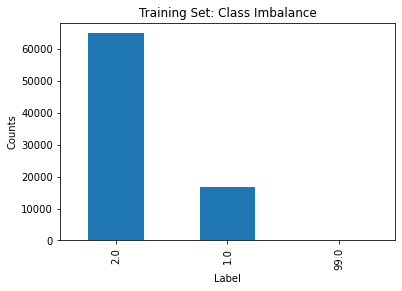

In [111]:
y_train.value_counts().plot(kind='bar', title='Training Set: Class Imbalance');
plt.xlabel('Label')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

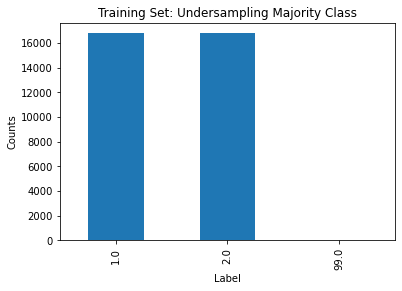

In [112]:
rus = RandomUnderSampler(random_state=1)
X_rus, y_rus = rus.fit_resample(X_train_fs, y_train)
y_rus.value_counts().plot(kind='bar', title='Training Set: Undersampling Majority Class');
plt.xlabel('Label')
plt.ylabel('Counts')

In [100]:
print('Size of training Set with class imbalance:', X_train_fs.shape)
print('Size of training Set with undersampling:', X_rus.shape)

Size of training Set with class imbalance: (81767, 18)
Size of training Set with undersampling: (33582, 18)


#### 10 fold cross-validation

In [101]:
clfDT_rus = DecisionTreeClassifier()

# Perform 10-fold cross-validation with custom scoring metrics
cv_results = cross_validate(clfDT_rus, X_rus, y_rus, cv=10, scoring=scoring)

# Print the results
print(cv_results)

{'fit_time': array([0.14504361, 0.14203215, 0.14203215, 0.13604903, 0.14302063,
       0.13502359, 0.14502525, 0.14203763, 0.14303803, 0.13402295]), 'score_time': array([0.00899601, 0.00801349, 0.00798917, 0.00799632, 0.00800776,
       0.00799727, 0.01100063, 0.01000237, 0.00800276, 0.00800371]), 'test_accuracy': array([0.5912474 , 0.59005656, 0.5807028 , 0.58755211, 0.58576534,
       0.60750447, 0.58487195, 0.59201906, 0.57593806, 0.58933889]), 'test_precision': array([0.59331307, 0.58728324, 0.58108917, 0.58919903, 0.58470588,
       0.60561732, 0.58377425, 0.59008746, 0.5753101 , 0.58917955]), 'test_recall': array([0.58095238, 0.6051221 , 0.57832043, 0.57832043, 0.59201906,
       0.61643836, 0.59142347, 0.60273973, 0.58010721, 0.59023228]), 'test_f1_score': array([0.58706767, 0.59606923, 0.57970149, 0.58370905, 0.58833975,
       0.61097993, 0.58757396, 0.59634649, 0.5776987 , 0.58970544])}


In [102]:
# 10-fold cross-validation
print("Baseline Classifier F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_results['test_f1_score']),
                                                                      std=np.std(cv_results['test_f1_score'])))

Baseline Classifier F1-score
Mean: 0.5897191710315406
Std: 0.009114642953558733


In [103]:
# Fit Time
print("Baseline Classifier Average Fit Time: {fit}".format(fit=np.mean(cv_results['fit_time'])))

Baseline Classifier Average Fit Time: 0.1407325029373169


Using the Testing Set:

In [104]:
# Create Decision Tree Classifier object
clfDT_rus = DecisionTreeClassifier(random_state=1)

# Fit the model
clfDT_rus.fit(X_rus, y_rus)

# Predicting labels for the Test Set
y_pred_rus = clfDT_rus.predict(X_test_fs)

print(confusion_matrix(y_test, y_pred_rus))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

[[ 4268  2912]
 [11361 16502]]


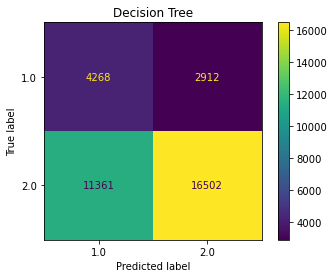

In [113]:
cm = confusion_matrix(y_test, y_pred_rus, labels=clfDT_rus.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clfDT_rus.classes_)
disp.plot()
plt.title('Decision Tree')
plt.show()

In [106]:
print("Accuracy:", accuracy_score(y_test, y_pred_rus))
print("Precision:", precision_score(y_test, y_pred_rus))
print("Recall:", recall_score(y_test, y_pred_rus))
print("F1 Score:", f1_score(y_test, y_pred_rus))
print("MCC:", matthews_corrcoef(y_test, y_pred))

Accuracy: 0.5927003966555375
Precision: 0.2730820909847079
Recall: 0.5944289693593314
F1 Score: 0.37423823929150773
MCC: 0.16523814459864605


In [107]:
print(classification_report(y_test, y_pred_rus))

              precision    recall  f1-score   support

         1.0       0.27      0.59      0.37      7180
         2.0       0.85      0.59      0.70     27863

    accuracy                           0.59     35043
   macro avg       0.56      0.59      0.54     35043
weighted avg       0.73      0.59      0.63     35043



### Removing the demographic feature of gender
- Only using Behavioural/Beliefs features

In [65]:
X_rus.columns

Index(['Gender', 'W5B', 'W11A', 'MH2B', 'W15_1A', 'W15_1B', 'W15_1C', 'W15_1D',
       'W15_1E', 'W15_2A', 'W15_2B', 'MH3B', 'MH3D', 'MH5', 'MH6', 'W28',
       'W29', 'W30'],
      dtype='object')

In [66]:
X_rus.drop('Gender', axis=1, inplace=True)

In [67]:
X_rus

,W5B,W11A,MH2B,W15_1A,W15_1B,W15_1C,W15_1D,W15_1E,W15_2A,W15_2B,MH3B,MH3D,MH5,MH6,W28,W29,W30
0,2.0,1,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2,99.0,99.0,2.0
1,1.0,2,1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0
2,4.0,1,4,4.0,4.0,1.0,4.0,4.0,2.0,2.0,4.0,1.0,1.0,1,5.0,1.0,1.0
3,1.0,2,3,3.0,4.0,2.0,1.0,4.0,1.0,1.0,2.0,3.0,3.0,2,3.0,3.0,1.0
4,4.0,1,2,2.0,4.0,2.0,2.0,4.0,1.0,4.0,2.0,2.0,3.0,1,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33577,2.0,2,3,2.0,2.0,2.0,2.0,4.0,4.0,2.0,2.0,3.0,3.0,2,1.0,3.0,1.0
33578,3.0,2,3,2.0,2.0,1.0,1.0,2.0,4.0,1.0,2.0,1.0,2.0,2,3.0,1.0,2.0
33579,4.0,1,1,4.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,2.0,1,4.0,3.0,99.0
33580,1.0,99,99,99.0,99.0,99.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,2,6.0,2.0,99.0


In [68]:
X_test_fs.drop('Gender', axis=1, inplace=True)

In [69]:
clfDT_rus = DecisionTreeClassifier()

# Perform 10-fold cross-validation with custom scoring metrics
cv_results = cross_validate(clfDT_rus, X_rus, y_rus, cv=10, scoring=scoring)

# Print the results
print(cv_results)

{'fit_time': array([0.13104153, 0.13103533, 0.13902569, 0.1290288 , 0.12803626,
       0.13201904, 0.13103533, 0.14702153, 0.13003469, 0.13403749]), 'score_time': array([0.0080018 , 0.00799608, 0.00900793, 0.00900197, 0.00899458,
       0.01001859, 0.00800157, 0.00900149, 0.00999498, 0.00999594]), 'test_accuracy': array([0.59481989, 0.583507  , 0.58368076, 0.57712924, 0.580405  ,
       0.58993448, 0.59767719, 0.58129839, 0.57683145, 0.58546754]), 'test_precision': array([0.59719683, 0.58274232, 0.58308693, 0.57843731, 0.58054893,
       0.58945498, 0.59738717, 0.57959184, 0.57789855, 0.58618619]), 'test_recall': array([0.58333333, 0.58725432, 0.58725432, 0.56879095, 0.57951161,
       0.59261465, 0.59916617, 0.59201906, 0.56998213, 0.58129839]), 'test_f1_score': array([0.59018368, 0.58498962, 0.5851632 , 0.57357357, 0.58002981,
       0.59103059, 0.59827535, 0.58573954, 0.57391304, 0.58373206])}


In [70]:
# 10-fold cross-validation
print("Baseline Classifier F1-score\nMean: {mean}\nStd: {std}".format(mean=np.mean(cv_results['test_f1_score']),
                                                                      std=np.std(cv_results['test_f1_score'])))

Baseline Classifier F1-score
Mean: 0.5846630463200368
Std: 0.007202125239739616


In [57]:
# Create Decision Tree Classifier object
clfDT_rus = DecisionTreeClassifier(random_state=1)

# Fit the model
clfDT_rus.fit(X_rus, y_rus)

# Predicting labels for the Test Set
y_pred_rus = clfDT_rus.predict(X_test_fs)

print(confusion_matrix(y_test, y_pred_rus))

# TN, FP
# FN, TP
## y_pred: Predicted labels
## y_test: True Labels

[[ 4220  2960]
 [11390 16473]]


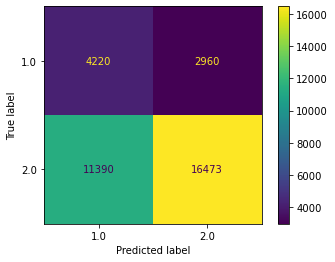

In [58]:
cm = confusion_matrix(y_test, y_pred_rus, labels=clfDT_rus.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clfDT_rus.classes_)
disp.plot()
plt.show()

In [59]:
print("Accuracy:", accuracy_score(y_test, y_pred_rus))
print("Precision:", precision_score(y_test, y_pred_rus))
print("Recall:", recall_score(y_test, y_pred_rus))
print("F1 Score:", f1_score(y_test, y_pred_rus))

Accuracy: 0.590503096196102
Precision: 0.2703395259449071
Recall: 0.5877437325905293
F1 Score: 0.3703378674857394
